In [6]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import Dropout
import matplotlib.pyplot as plt
import pickle

In [49]:

def preprocess(MAX_NB_WORDS = 100000, MAX_SEQUENCE_LENGTH = 500):

    #MAX_NB_WORDS is equal to the maximum amounts of words to be used in the vector space
    #MAX_SEQUENCE_LENGTH is the maximum amount of words for each comment
    #EMBEDDING_DIM is fixed? why is this look it up.

    df = pd.read_csv('reddit_train.csv')

    # print(df.head(5))
    # print(df.info())
    # print(df['subreddits'].unique())

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df['comments'].values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    X = tokenizer.texts_to_sequences(df['comments'].values)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', X.shape)


    Y = pd.get_dummies(df['subreddits']).values
    print('Shape of label tensor:', Y.shape)

    return X, Y

In [52]:

def preprocess_test(tokenizer, MAX_NB_WORDS = 100000, MAX_SEQUENCE_LENGTH = 500):
    df = pd.read_csv('reddit_test.csv')

#     tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
#     tokenizer.fit_on_texts(df['comments'].values)
#     word_index = tokenizer.word_index
#     print('Found %s unique tokens.' % len(word_index))

    X = tokenizer.texts_to_sequences(df['comments'].values)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', X.shape)

    return X


In [17]:

def train(X, Y, MAX_NB_WORDS = 100000, EMBEDDING_DIM = 100):

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)


    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(20, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    epochs = 5
    batch_size = 64

    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])



    model.save('2_LSTM_250.h5')
    model.save_weights('2_LSTM_250_weights.h5')

    accr = model.evaluate(X_test,Y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show();


    plt.title('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='test')
    plt.legend()
    plt.show();


    return model


In [55]:
X_train, y_train, token = preprocess()

Found 90816 unique tokens.
Shape of data tensor: (70000, 500)
Shape of label tensor: (70000, 20)


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
X_test = preprocess_test(tokenizer)

(63000, 500) (63000, 20)
(7000, 500) (7000, 20)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 56700 samples, validate on 6300 samples
Epoch 1/5
56700/56700 [==============================] - 2595s 46ms/step - loss: 2.5828 - acc: 0.1678 - val_loss: 2.1803 - val_acc: 0.2875
Epoch 2/5
56700/56700 [==============================] - 2482s 44ms/step - loss: 1.9386 - acc: 0.3634 - val_loss: 1.8766 - val_acc: 0.4054
Epoch 3/5
56700/56700 [==============================] - 4603s 81ms/step - loss: 1.5820 - acc: 0.4908 - val_loss: 1.7242 - val_acc: 0.4640
Epoch 4/5
56700/56700 [==============================] - 5294s 93ms/step - loss: 1.3360 - acc: 0.5855 - val_loss: 1.7009 - val_acc: 0.5000
Epoch 5/5
7000/7000 [==============================] - 90s 13ms/step
Test set
  Loss: 1.749
  Accuracy: 0.517


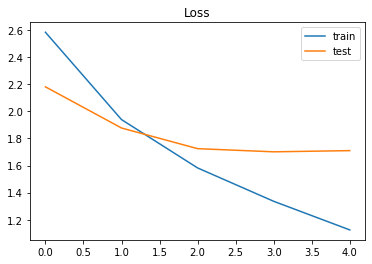

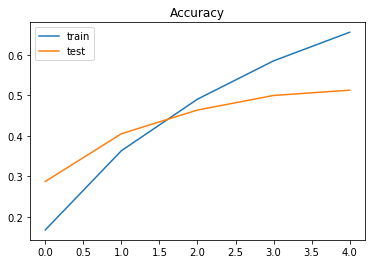

In [18]:
model = train(X_train,y_train)

In [22]:
y_prediction = model.predict(X_test)

In [24]:
y_prediction

array([[1.3236945e-05, 1.9802204e-05, 2.4505591e-05, ..., 1.1028695e-05,
        8.5848314e-06, 3.5520939e-06],
       [1.1391341e-03, 1.1526465e-03, 1.8938459e-03, ..., 6.3539221e-04,
        4.8433147e-02, 6.2390859e-04],
       [4.0471391e-03, 2.5787091e-04, 6.9556790e-03, ..., 4.5768751e-04,
        1.5711419e-04, 3.5685487e-04],
       ...,
       [7.7337716e-03, 7.8416431e-01, 1.0545871e-03, ..., 2.1900120e-03,
        5.8440072e-04, 6.9753896e-03],
       [2.5944098e-07, 4.6097644e-05, 2.2167475e-05, ..., 1.7674386e-08,
        4.2792581e-07, 5.1855911e-09],
       [1.8814668e-03, 6.5140612e-04, 8.9981401e-04, ..., 1.1176984e-04,
        3.8206330e-05, 8.6475867e-01]], dtype=float32)

In [34]:
y_prediction.shape

(30000, 20)

In [21]:
df = pd.read_csv('reddit_train.csv')

In [40]:
subreddits = np.asarray(sorted(df['subreddits'].unique()))

In [41]:
type(subreddits)

numpy.ndarray

In [43]:
labels = (subreddits[np.argmax(y_prediction, axis=1)])

In [44]:
type(labels)

numpy.ndarray

In [45]:
results = pd.DataFrame({'Category': labels})

In [46]:
results.index.name = "Id"

In [48]:
results

,Category
Id,
0,baseball
1,europe
2,anime
3,europe
4,funny
5,Overwatch
6,hockey
7,anime
8,GlobalOffensive


In [49]:
results.to_csv("prediction_2.csv")

In [4]:
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 500

df = pd.read_csv('reddit_train.csv')

# print(df.head(5))
# print(df.info())
# print(df['subreddits'].unique())

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['comments'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['comments'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Y = pd.get_dummies(df['subreddits']).values
print('Shape of label tensor:', Y.shape)

Found 90816 unique tokens.
Shape of data tensor: (70000, 500)
Shape of label tensor: (70000, 20)


In [5]:
df_test = pd.read_csv('reddit_test.csv')

X_test = tokenizer.texts_to_sequences(df_test['comments'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (30000, 500)


In [7]:
model = load_model('2_LSTM_250.h5')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
